 # Benzamidine binding to Trypsin

In [1]:
import pyemma
pyemma.__version__

u'1.2.1+198.gd343265'

This notebook has been tested for version 1.2.1. If you are using a different version some adaptations may be required.
Now we import a few general packages, including basic numerics and algebra routines (numpy) and plotting routines (matplotlib), and makes sure that all plots are shown inside the notebook rather than in a separate window (nicer that way).

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


Now we import the PyEMMA modules required later.

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mpl
from pyemma import config

## Trypsin/Benzamidine - load data

In [4]:
indir = './data'
topfile =  indir+'/tryp_ben_protein.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('-200ns.xtc'):
        traj_list.append(os.path.join(indir,filename))

We can decide here which coordinates we would like to use in the further analysis.

In [5]:
feat = coor.featurizer(topfile)
benzamidine_indices = feat.select('resname BEN and (name C7)')
Trp_indices = feat.select_Ca()
feat.add_contacts([(a,b) for a in benzamidine_indices for b in Trp_indices], threshold=0.5)
print 'number of contacts = ', feat.dimension()
#feat.describe()

number of contacts =  223


In [6]:
inp = coor.source(traj_list, feat)
print 'number of trajectories = ',inp.number_of_trajectories()
print 'trajectory length = ',inp.trajectory_length(0)
print 'number of dimension = ',inp.dimension()

number of trajectories =  50
trajectory length =  200
number of dimension =  223


In addition to the data used for the analysis, we would like to analyze the distance between Asp171 and Benzamidine.

In [7]:
feat_dist = coor.featurizer(topfile)
benzamidine_C7_indices = feat_dist.select('resname BEN and (name C7)')
Asp171_CG_indices = feat_dist.select('resid 170 and (name CG)')
feat_dist.add_distances([(benzamidine_C7_indices[0],Asp171_CG_indices[0])])
feat_dist.describe()

['DIST: BEN 224 C7 3227 - ASP 170 CG 2471']

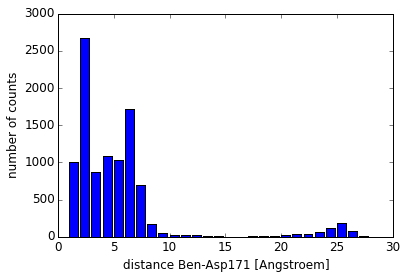

In [8]:
dist_inp = coor.source(traj_list, feat_dist)
dist_array = dist_inp.get_output()
dist_array = np.array(dist_array)
c_arr = np.concatenate(dist_array[:,:,0])
dc_arr = np.divide(10.0,c_arr)
int_c_arr = dc_arr.astype(int)
dist_histo = np.bincount(int_c_arr, minlength=20);
ind = np.arange(len(dist_histo))
plt.bar(ind, dist_histo, log=False)
plt.xlabel('distance Ben-Asp171 [Angstroem]')
plt.ylabel('number of counts')

## TICA and clustering

In [9]:
tica_lag = 20      # tica lagtime

In [10]:
tica_obj = coor.tica(inp, lag=tica_lag, kinetic_map=True, var_cutoff=0.8)#, dim=tica_dim)

2015-07-24 15:17:13,016 coordinates.transform.TICA[2] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-24 15:17:13,017 coordinates.transform.TICA[2] INFO     Running TICA with tau=20; Estimating two covariance matrices with dimension (223, 223)


9


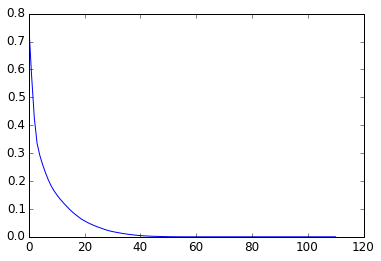

In [11]:
print tica_obj.dimension()
cum_variance = tica_obj.cumvar
plot(1-cum_variance)

In [12]:
Y = tica_obj.get_output() # get tica coordinates

/storage/mi/nplattner/miniconda/envs/PyE-devR/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


<matplotlib.contour.QuadContourSet instance at 0x7f7c502f6f80>

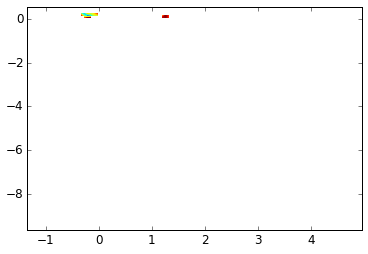

In [13]:
npY = np.array(Y)
npYc = np.concatenate(npY)
# histogram data
z,x,y = np.histogram2d(npYc[:,0],npYc[:,1], bins=100)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
contourf(F.T, 100,extent=extent)

### Clustering

In [14]:
n_clusters = 200      # number of k-means clusters
cl_metric = 'euclidean' # clustering metric

In [15]:
clustering = coor.cluster_kmeans(Y,k=n_clusters,max_iter=1000)

2015-07-24 15:17:48,625 coordinates.clustering.KmeansClustering[3] INFO     reset (previous) parametrization state, since data producer has been changed.
2015-07-24 15:17:48,958 coordinates.clustering.KmeansClustering[3] INFO     Accumulated all data, running kmeans on (10000, 9)
2015-07-24 15:17:49,041 coordinates.clustering.KmeansClustering[3] INFO     Cluster centers converged after 3 steps.


In [16]:
dtrajs = coor.assign_to_centers(Y, centers=clustering.clustercenters, stride=1, return_dtrajs=True, metric=cl_metric)

2015-07-24 15:17:49,046 coordinates.clustering.AssignCenters[5] INFO     reset (previous) parametrization state, since data producer has been changed.


In order to analyze the distribution of the data to the cluster centers we make a histogram of the discrete trajectories.

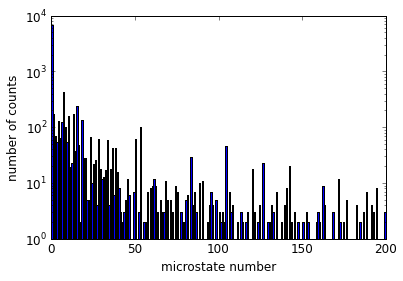

In [17]:
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
ind = np.arange(len(histogram))
plt.bar(ind, histogram, log=True)
plt.xlabel('microstate number')
plt.ylabel('number of counts')

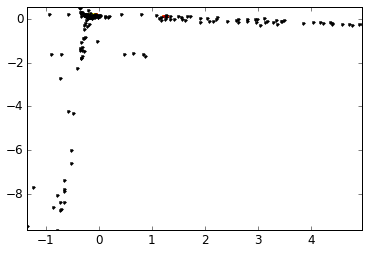

In [18]:
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
contourf(F.T, 100, extent=extent)
plot(cc_x,cc_y, linewidth=0, marker='.', color='black')

In [19]:
# analyze microstate distribution as a function of Asp171-Ben distance
distances = dist_array[:,:,0]
nstates = len(clustering.clustercenters)
statecount = [0 for n in range(nstates)]
statedist = [0.0 for n in range(nstates)]
for i in range(len(dtrajs)):
    for j in range(len(dtrajs[i])):
        state = dtrajs[i][j]
        dist = distances[i][j]
        statecount[state] += 1
        statedist[state] += dist 
distogram = np.zeros((nstates))
for i in range(nstates):
    distogram[i] = float(statedist[i])/float(statecount[i])
distogram = np.divide(distogram,0.1)

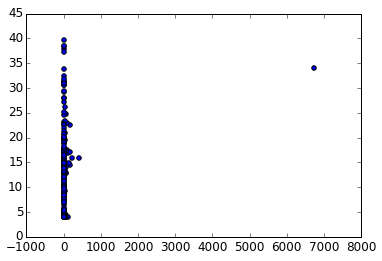

In [20]:
# did we resolve bound and unbound state?
scatter(histogram,distogram)

# Implied timescales

In [21]:
its = msm.timescales_msm(dtrajs, lags=50, nits=5, errors='bayes')

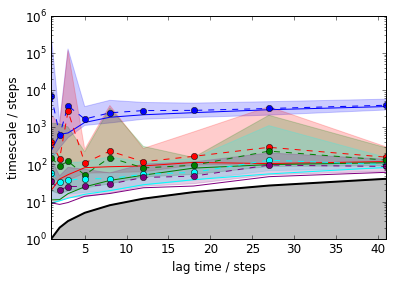

In [22]:
mpl.plot_implied_timescales(its, ylog=True)

# Estimate MSM

In [23]:
M = msm.bayesian_markov_model(dtrajs, 10)
print 'fraction of states used = ', M.active_state_fraction
print 'fraction of counts used = ', M.active_count_fraction

fraction of states used =  0.96
fraction of counts used =  0.9991


/storage/mi/nplattner/miniconda/envs/PyE-devR/lib/python2.7/site-packages/msmtools/analysis/dense/pcca.py:292: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


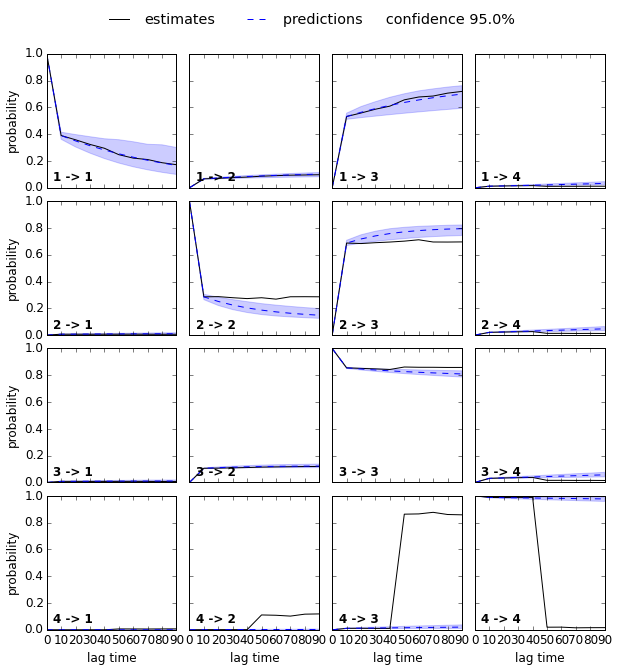

In [24]:
# validate
cktest = M.cktest(4)
mpl.plot_cktest(cktest);

In [25]:
pi = M.stationary_distribution # stationary distribution
F_pi = -np.log(pi)  # free energy based on stationary distribution

In [26]:
connected = M.connected_sets[0]
c_cc_x = cc_x[connected]
c_cc_y = cc_y[connected]

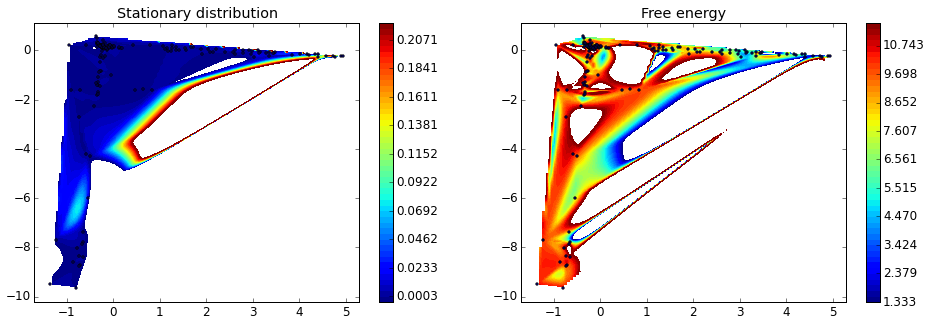

In [27]:
fig = plt.figure(figsize=(16,5))
matplotlib.rcParams.update({'font.size': 12})
ax1=plt.subplot(121)
ax1.set_title('Stationary distribution')
ax1 = mpl.scatter_contour(c_cc_x, c_cc_y, pi)

ax2=plt.subplot(122)
ax2.set_title('Free energy')
ax2 = mpl.scatter_contour(c_cc_x, c_cc_y, F_pi)

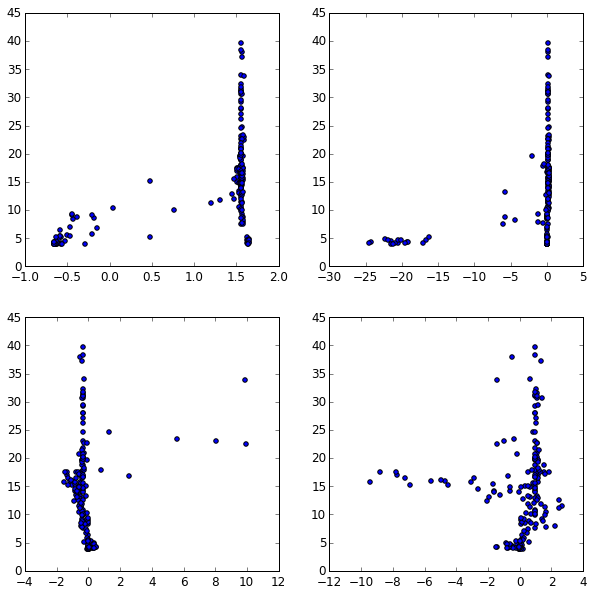

In [28]:
c_distogram = distogram[connected]
N=4
ngrid = int(math.ceil(sqrt(1.0*N)))
figure(figsize=(10,10))
for i in range(N):
    subplot2grid((ngrid,ngrid),(i/ngrid,i%ngrid))
    scatter(M.eigenvectors_right()[:,i+1], c_distogram)
    #semilogy()

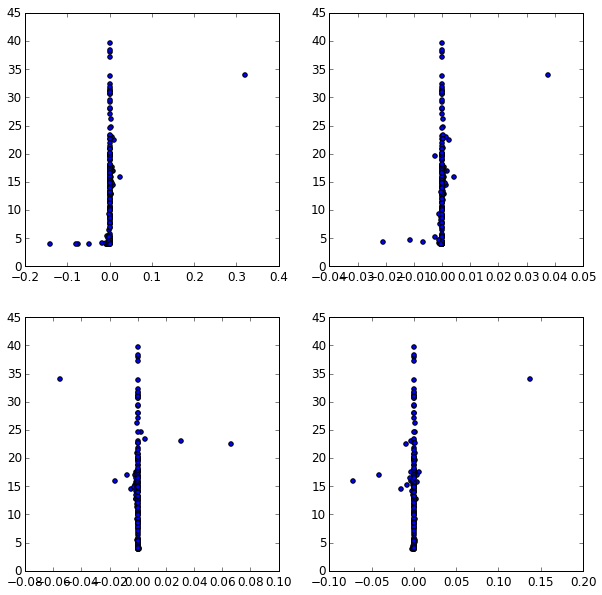

In [29]:
c_distogram = distogram[connected]
N=4
ngrid = int(math.ceil(sqrt(1.0*N)))
figure(figsize=(10,10))
for i in range(N):
    subplot2grid((ngrid,ngrid),(i/ngrid,i%ngrid))
    scatter(M.eigenvectors_left()[i+1], c_distogram)
    #semilogy()

# PCCA

In [30]:
n_sets = 4
M.pcca(n_sets)
pcca_dist = M.metastable_distributions
membership=M.metastable_memberships  # get PCCA memberships

In [31]:
pcca_samples = M.sample_by_distributions(pcca_dist, 10)

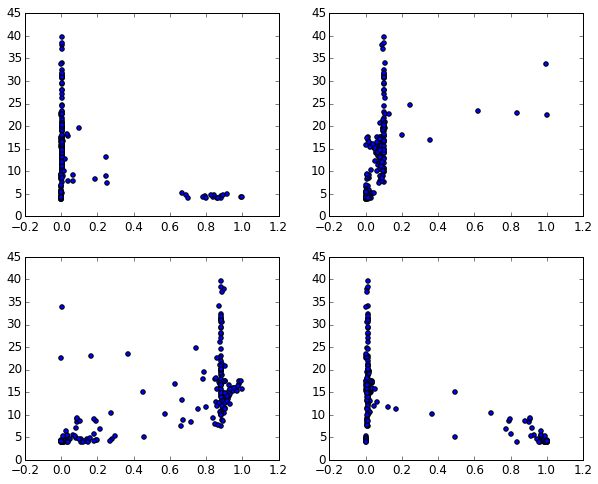

In [32]:
c_distogram = distogram[connected]
fig = plt.figure(figsize=(10,8))

ax1=plt.subplot(221)
ax1 = scatter(membership[:,0],c_distogram)

ax2=plt.subplot(222)
ax1 = scatter(membership[:,1],c_distogram)

ax3=plt.subplot(223)
ax1 = scatter(membership[:,2],c_distogram)

ax4=plt.subplot(224)
ax1 = scatter(membership[:,3],c_distogram)

In [33]:
coor.save_traj(inp, pcca_samples[0], './out_conCA/pcca1_10samples.xtc')
coor.save_traj(inp, pcca_samples[1], './out_conCA/pcca2_10samples.xtc')
coor.save_traj(inp, pcca_samples[2], './out_conCA/pcca3_10samples.xtc')
coor.save_traj(inp, pcca_samples[3], './out_conCA/pcca4_10samples.xtc')

2015-07-24 15:18:36,304 coordinates.api INFO     Created file ./out_conCA/pcca1_10samples.xtc
2015-07-24 15:18:38,500 coordinates.api INFO     Created file ./out_conCA/pcca2_10samples.xtc
2015-07-24 15:18:40,860 coordinates.api INFO     Created file ./out_conCA/pcca3_10samples.xtc
2015-07-24 15:18:42,198 coordinates.api INFO     Created file ./out_conCA/pcca4_10samples.xtc


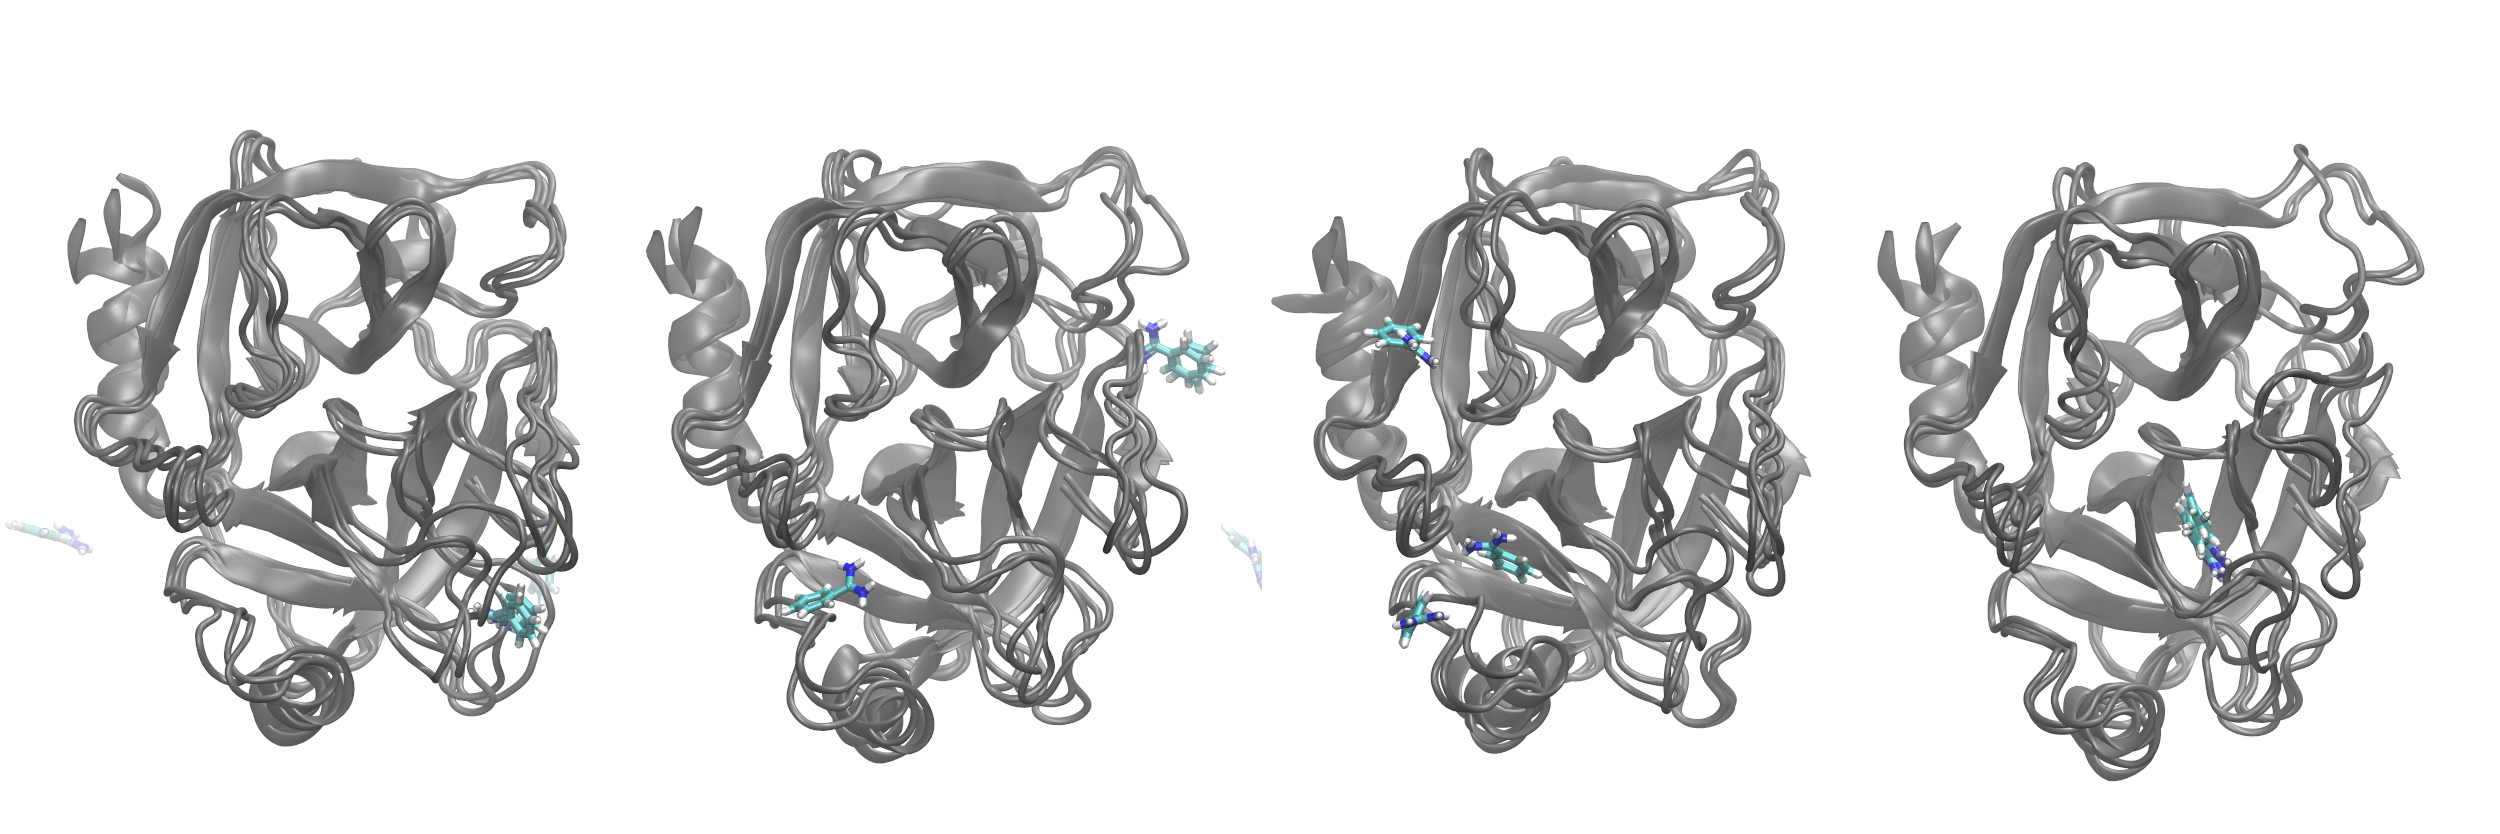

In [35]:
from IPython.display import Image
Image(filename='./out_conCA/conCA-pcca.png', width=1000)